### Test sleep scoring
- Tried some unsupervised neural network from sklearn, it did not work that well

In [3]:
import numpy as np
from neuropy.analyses.brainstates import detect_brainstates_epochs
from neuropy.plotting import plot_probe
from neuropy.core import Epoch
from neuropy.utils.signal_process import FourierSg
from scipy.ndimage import gaussian_filter1d
from neuropy.analyses.brainstates import correlation_emg
from hfuncs import whiten_signal
from scipy import stats
from neuropy.analyses.brainstates import hmmfit1d
import matplotlib.pyplot as plt
from neuropy.plotting import plot_hypnogram
import subjects

smooth = lambda arr:gaussian_filter1d(arr,sigma=2/1)

sess = subjects.sd.ratUday1[0]
maze = sess.paradigm["maze"].flatten()

pre = sess.paradigm['pre'].flatten()
maze = sess.paradigm['maze'].flatten()
post = sess.paradigm['post'].flatten()
period = [pre[0]+3600,post[1]]

### Using neuropy

In [4]:
signal = sess.eegfile.get_signal()
epochs = detect_brainstates_epochs(
    signal=signal,
    probe=sess.probegroup,
    delta_channel=127,
    theta_channel=112,
    window=10,
    overlap=9,
    behavior_epochs=sess.paradigm['maze'],
    ignore_epochs=sess.artifact,
    plot=True
)

epochs.save(sess.filePrefix.with_suffix('.brainstates'))
# _,ax = plt.subplots() 

# plot_hypnogram(epochs,ax=ax)


channel for sleep detection: (112, 127)
spectral properties calculated
starting emg calculation


In [5]:
epochs.save(sess.filePrefix.with_suffix('.brainstates'))

/data/Clustering/sessions/RatV/RatVDay2SD/RatV_Day2SD_2021-10-04_08-02-10.brainstates saved


In [ ]:
epochs_labels = epochs.labels
for i in range(1, len(epochs)):
    if epochs_labels[i]=='REM':
        print(epochs_labels[i],epochs_labels[i-1])
    if (epochs_labels[i] == "REM") and (epochs_labels[i - 1] == "QW"):
        print('he')
        epochs_labels[i] = "QW"
    if (epochs_labels[i] == "REM") and (epochs_labels[i - 1] == "AW"):
        epochs_labels[i] = "AW"

epochs_labels[1] = 'munna'
new_epochs = epochs.set_labels(epochs_labels)



### Probe layout

/home/bapung/miniconda3/envs/data_analysis/lib/python3.10/site-packages/pandas/core/indexes/base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


<AxesSubplot:title={'center':'Probe 256ch'}>

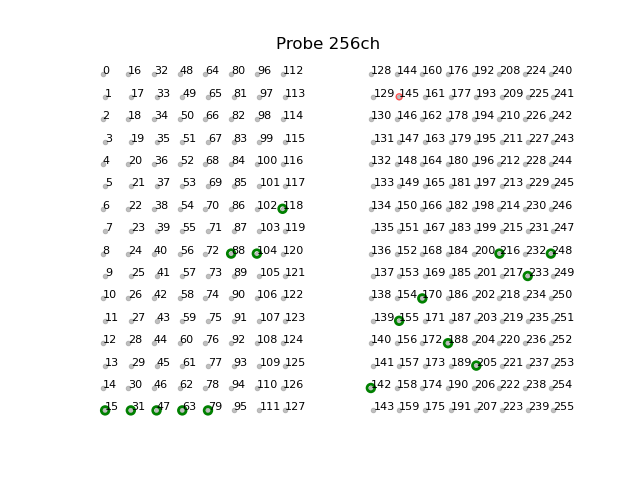

In [3]:
plot_probe(sess.probegroup,annotate_channels=sess.ripple.metadata['channels'])

### emg estimation

In [ ]:
all_channels = np.concatenate(sess.probegroup.get_connected_channels()).astype('int')
signal = sess.eegfile.get_signal(t_start=period[0],t_stop=period[1])
emg = correlation_emg(signal,sess.probegroup,10,9)
emg = smooth(emg)

### Choose best theta and delta channel

In [ ]:
import scipy.signal as sg
from numpy.polynomial import polynomial
from dip import diptst
from tqdm.notebook import tqdm
from neuropy.utils.mathutil import min_max_scaler

# channels = [19,25,2,1,93,87,189,183]
def get_dip_pval(f,sxx,band,):
    indices = (f>=band[0]) & (f<=band[1])
    f_band = np.log10(f[indices])
    spect_band = np.log10(sxx[indices,:])

    invalid_col = ~np.isfinite(spect_band).any(axis=0)
    linfit = np.polyfit(f_band,spect_band[:,~invalid_col],deg=1)
    slopes = gaussian_filter1d(linfit[0],2)

    bins = np.arange(1,4,0.02)
    hist_slopes = np.histogram(np.abs(slopes),bins=bins)[0]
    return diptst(hist_slopes,is_hist=True)[1] 

def get_dip_pval_ratio(f,sxx,band1,band2):
    indices1 = (f>=band1[0]) & (f<=band1[1])
    indices2 = (f>=band2[0]) & (f<=band2[1])
    spect_ratio = sxx[indices1,:].mean(axis=0)/sxx[indices2,:].mean(axis=0)

    spect_ratio = gaussian_filter1d(spect_ratio,2)
    spect_ratio = min_max_scaler(spect_ratio)
    bins = np.linspace(0,1,200)
    hist_slopes = np.histogram(spect_ratio,bins=bins)[0]
    return diptst(hist_slopes,is_hist=True)[1] 


chans = all_channels
sw_dip_pval,theta_dip_pval = [],[]
for chan in tqdm(chans):
    signal = sess.eegfile.get_signal(chan)
    # spect = FourierSg(signal,window=60,overlap=10)
    f, t, spect = sg.spectrogram(
        signal.traces[0], fs=1250, nperseg=2 * 1250, noverlap=0,axis=-1
    )
    # spect = gaussian_filter1d(spect,sigma=4,axis=0)

    sw_dip_pval.append(get_dip_pval(f,spect,(4,90)))
    theta_dip_pval.append(get_dip_pval_ratio(f,spect,(5,10),(2,20)))


best_delta_chan = chans[np.argmin(sw_dip_pval)]
best_theta_chan = chans[np.argmin(theta_dip_pval)]
print(best_delta_chan,best_theta_chan)

### Sleep scoring

In [ ]:
freqs = np.geomspace(0.5,100,100)
spect_kw = dict(window=10, overlap=9, freqs=freqs,norm_sig=True)
delta_lfp = sess.eegfile.get_signal(9, *period)
theta_lfp = sess.eegfile.get_signal(13, *period)
# theta_lfp = whiten_signal(theta_lfp)
sg_deltachan = FourierSg(delta_lfp, **spect_kw)
delta = smooth(sg_deltachan.delta)

sg_thetachan = FourierSg(theta_lfp, **spect_kw)
theta = smooth(sg_thetachan.theta)
# band30 = smooth(sg_thetachan.get_band_power(1, 30))
delta_full = smooth(sg_thetachan.get_band_power(2, 20))
# chewing = smooth(FourierSg(theta_lfp, **spect_kw).get_band_power(2, 16))
theta_ratio = theta/ delta_full


l = np.min([len(emg), len(theta)])

# band30_bool = hmmfit1d(1 / band30[:l])
# band30_bool = hmmfit1d(1 / band30[:l])
emg_bool = hmmfit1d(emg[:l],startprob_prior=np.array([0.2,0.8]))
theta_ratio_bool,mus = hmmfit1d(theta_ratio[:l],ret_means=True,startprob_prior=np.array([0.2,0.8]))
delta_bool = hmmfit1d(delta[:l])


assert len(theta_ratio_bool) == len(emg_bool)

states = np.array(["QW"] * len(theta_ratio_bool), dtype="U4")
states[(theta_ratio_bool == 1) & (emg_bool == 1)] = "AW" 
states[(emg_bool == 0) & (theta_ratio_bool == 0)] = "QW"
states[ (emg_bool == 0) & (theta_ratio_bool == 1)] = "REM"
states[ (emg_bool == 0) & (theta_ratio_bool == 0)] = "NREM"

states_epochs= Epoch.from_string_array(states)


In [ ]:
from neuropy.plotting import plot_epochs

_,axs = plt.subplots(6,1,sharex=True)


axs[0].plot(stats.zscore(delta))
axs[0].set_ylim([-0.5,1.5])
ax = axs[0].twinx()
ax.plot(delta_bool,'k',alpha=0.5)
ax.set_ylim([-0.5,1.5])

axs[1].plot(theta_ratio,zorder=2)
# axs[1].set_ylim([-2.4,6])
ax = axs[1].twinx()
ax.plot(theta_ratio_bool,'k',lw=0.8,alpha=0.5,zorder=-1)
ax.set_ylim([-0.5,1.5])


# axs[2].plot(1/band30)
# axs[3].plot(thetah_sxx/delta_sxx)
axs[3].plot(emg)
ax = axs[3].twinx()
ax.plot(emg_bool,'k',lw=0.8,alpha=0.5,zorder=-1)
ax.set_ylim([-0.5,1.5])


# axs[4].fill_between(states)
plot_epochs(ax=axs[4],epochs=states_epochs,labels_order=['NREM','REM','QW','AW'],colors=subjects.colors_sleep)
# axs[4].plot(high_emg)
# axs[5].plot((1/band30[:l])/delta_sxx[:-1])
# axs[5].plot(stats.zscore(delta_full))



In [ ]:
_,axs = plt.subplots(8,1,sharex=True)

channels = sess.probegroup.get_connected_channels()[9][::2]
for i,chan in enumerate(channels):
    th_lfp = sess.eegfile.get_signal(chan,*period) 
    th = smooth(FourierSg(th_lfp,window=1,overlap=0.2).theta)
    axs[i].plot(th)
    # axs[i].set_yscale('log')
    axs[i].set_ylim([0,0.1])


In [ ]:
_,ax = plt.subplots()

param = stats.zscore(delta)
bins = np.linspace(-2,3,900)
hist_val = np.histogram(param,bins=bins)[0]
ax.plot(bins[:-1],hist_val)
# ax.set_yscale('log')
# ax.axvline(mus[0],ls='--')
# ax.axvline(mus[1],ls='--')
ax.axvline(bins[157])
ax.axvline(bins[203])


In [ ]:
from dip import diptst

diptst(hist_val,is_hist=True)

In [ ]:
_,ax = plt.subplots()

ax.plot(delta_sxx,theta_del_ratio,'.')
# ax.set_yscale('log')
# ax.axvline(mus[0],ls='--')
# ax.axvline(mus[1],ls='--')
